# EEML'25 Tutorial: Training Vision Transformer (ViT) encoders from scratch

Authors:

- Liliane Momeni (lmomeni@google.com)
- Nikhil Parthasarathy (nikparth@google.com)


**Abstract:** This tutorial is designed to provide a hands-on understanding of how to train powerful Vision Transformer (ViT) encoders from scratch 🚀. Part 1 will recap why ViT encoders are important, before diving into the three fundamental training paradigms. Part 2 will cover the classic fully supervised approach using labeled data. Part 3 will explore the self-supervised paradigm through Masked Autoencoders, where models learn rich features from the data itself without labels.  Finally, Part 4 covers contrastive learning with noisy supervision, using CLIP as our case study.

**Outline**:
- Part 1: Introduction to Vision Transformer encoders
- Part 2: Fully supervised ViT for Image Classification
- Part 3: Self-supervised Learning with Masked Autoencoders (MAE)
- Part 4 (Take-home task): Contrastive Language-Image Pre-training (CLIP)
- Part 5: Conclusion

**Slides**: The set of slides which accompany this tutorial can be found [here](https://docs.google.com/presentation/d/1TeG1pd0Bx4ijSEAFJNdUBGmm9tAvvbwZg8URty7cjWQ/edit?usp=sharing).

❗ Note: Parts 2, 3 and 4 of this tutorial do not require a GPU and can be run on a CPU. If you are able to obtain a Colab runtime with a GPU (you can do this by clicking Runtime -> Change runtime type, and set the hardware accelerator to GPU), it will run slightly faster.


## Part 1: Introduction to Vision Transformer encoders

**1.1 Vision Encoders**

A vision encoder is a neural network that converts an image into a compact numerical summary called an embedding or feature vector.

🖼️➡️🔢

- **What it does**: It acts as a translator, distilling complex pixel data into a format that a machine can understand and analyze.

- **What it captures**: This summary contains the image's essential visual and semantic content, such as the objects within it, their geometry, and how they relate to each other in the scene.

- **Why it's important**: By learning to create high-quality representations, vision encoders enable models to perform a vast array of visual tasks (such as image classification, object detection, semantic segmentation, and even image generation) with remarkable accuracy.

**1.2 The Vision Transformer (ViT): A Paradigm Shift**

As the Transformers architecture scaled well in Natural Language Processing, the same architecture was applied to images by creating small 2D patches of the image and treating them as tokens. The result was a Vision Transformer (ViT).

The primary strength of the ViT architecture is its ability to capture **global context** and **long-range dependencies** from the very first layer, a key difference from the hierarchical, localized feature extraction of CNNs. Summarising key differences below:

- Convolutional Neural Networks (CNNs): Process images hierarchically. They use sliding filters (kernels) to capture local features like edges and textures first. They must pass through many layers to gradually build up a global understanding of the entire scene.

- Vision Transformers (ViTs): Take a global-first approach. By treating an image as a sequence of patches, they use a mechanism known as self-attention (which we will explain in Part 2) to immediately understand how a patch in the top-left corner relates to a patch in the bottom-right, leading to a more holistic initial understanding of the scene.

**1.3 The Standard Workflow: Using Pretrained Models**

In practice, training a large model like a Vision Transformer (ViT) from scratch is computationally expensive and therefore rare. The standard workflow is to use a pretrained model, which has already learned a robust, general understanding of the visual world from a massive dataset like ImageNet-21k (containing over 14 million images).

Once you have this strong foundation, you typically follow one of two paths:

- **Fine-Tuning**: You adapt the model by continuing its training on a smaller, task-specific dataset (e.g., classifying medical images or identifying product defects).

- **Zero-Shot Inference**: For certain models, you can use them directly to make predictions on tasks or classes they have never explicitly been trained on.

While using pretrained models is the common approach, this tutorial will pull back the curtain and show you how these powerful encoders are built and trained from the ground up, giving you a fundamental understanding of how they truly work.

**1.4 Different training paradigms**


There are three primary paradigms for training these encoders, each with its own philosophy for learning visual representations. We will explore all of them in this tutorial series:

- **Fully Supervised Learning**: This is the classic approach where the model learns from a dataset containing images and their corresponding explicit labels (e.g., a picture of a golden retriever with the label "dog"). The model's goal is to correctly predict the label for a given image.

- **Self-Supervised Learning (SSL)**: This powerful paradigm enables a model to learn rich features directly from unlabeled data by solving a "pretext task". We will implement a Masked Autoencoder (MAE), where the model must reconstruct randomly hidden patches of an image, forcing it to learn the context and structure of the visual world.

- **Multimodal Contrastive Learning**: This approach trains a model to understand the relationship between data by learning which samples are similar and which are different. We will use CLIP (Contrastive Language-Image Pre-Training), which learns to match images with their corresponding text descriptions scraped from the web. The text provides a "noisy" but highly effective form of supervision.




## Part 2: Fully supervised [ViT](https://arxiv.org/abs/2010.11929) for Image Classification

This section will walk you through the fundamental components and training process for a Vision Transformer (ViT) in a fully supervised setting.
We will cover everything from loss function implementation and data preparation to model training and the critical analysis of its performance.
Each subsection corresponds to a hands-on exercise.

First off run the next cell to install the necessary libraries. As it might take a bit of time to finish installing, start reading Part 2.1.

In [1]:
# =========================================
#     Setup and Imports
# =========================================
import math

import einops
import einx

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"PyTorch version: {torch.__version__}")
print(f"Timm version: {timm.__version__}")

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu128
Timm version: 1.0.19
Using device: cuda


### Part 2.1: The Cross-Entropy Loss Function

At the heart of any classification task is the loss function, which quantifies how "wrong" our model's predictions are compared to the actual labels. For multi-class classification, the standard choice is the **Cross-Entropy Loss**.

Before calculating the loss, a model outputs raw, unbounded scores called logits. To turn these logits into a probability distribution that sums to 1, we use the **Softmax** function. Below, we show an example where we are trying to classify 3 images (of size 32x32 pixels) and the total number of classes $C$ is equal to 3 (cat, dog, horse).

<center>
<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/softmax.png" width="600" height="250" style="display: block; margin: auto;"></center>


The Softmax equation for the score of a class $i$ is:

$$ \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}} $$

Where:

* $z_i$ is the logit for class $i$.
* $C$ is the total number of classes.


Cross-entropy then measures the difference between this predicted probability distribution and the "true" distribution (where the correct class has a probability of 1 and all others have a probability of 0).

Mathematically, for a single example, the cross-entropy loss is:

$$L_{CE} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

Where:

* $C$ is the number of classes.
* $y_i$ is the true probability for class $i$ (it's 1 for the correct class, 0 otherwise).
* $\hat{y}_i$ is the model's predicted probability for class $i$.

When you're training a classification model and using cross-entropy as your loss function, you are effectively trying to minimize the negative log-likelihood of your model's predictions with respect to the true labels.
Note, below we plot the range of the **Negative Log-Likelihood** operation: $L(\textbf{y}) = - \log(\textbf{y})$

<center>
<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png" width="400" height="300"></center>

We observe the loss function heavily penalizes the model if it assigns a low probability to the correct class (reaching infinity when the predicted probability is 0), while no loss is applied when the predicted probability is 1.  

<center>
<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log_demo.png" width="800" height="250">
</center>

**Take-away**: The Cross-Entropy loss combines two steps: 1. A softmax function to convert the model's raw output scores (logits) into probabilities. 2. It then calculates the Negative Log-Likelihood, which heavilily penalises the model if it assigns a low probability to the correct class.

In the next exercise, you will implement this from scratch to solidify your understanding before we use PyTorch's built-in version.



In [2]:
# @title Hint 1 { display-mode: "form" }

# The task is to implement the Cross-Entropy loss.
# Remember the first step is Softmax.
# Softmax takes logits and converts them to probabilities. You can make use of torch.exp() for this step.


# Step 1: Solution
#   exps = torch.exp(logits)
#   sum_exps = torch.sum(exps, dim=1, keepdim=True)
#   softmax_probs = exps / sum_exps


# Example
B, C = 3, 3  # Batch size x Classes
logits = torch.randn(size=(B, C))  # Batch size x Classes
exps = torch.exp(logits)
sum_exps = torch.sum(exps, dim=1, keepdim=True)
softmax_probs = exps / sum_exps

print(softmax_probs)
assert torch.allclose(
    softmax_probs.sum(dim=1), torch.ones(3)
)  # Make sure they sum to one for each sample

tensor([[0.1157, 0.7831, 0.1012],
        [0.3921, 0.5181, 0.0898],
        [0.1997, 0.5034, 0.2968]])


In [3]:
# @title Hint 2 { display-mode: "form" }

# The next step is Negative Log-Likelihood.
# Negative Log-Likelihood takes the predicted probability of the *correct* class and calculates -log(probability).
# For this step you can make use of torch.log().


# Step 2: Solution
#   log_probs = - torch.log(softmax_probs)

# Example
labels = torch.tensor([0, 2, 1])
labels_ohe = F.one_hot(labels, num_classes=C)  # One-hot encoding of the labels
log_probs = -torch.log(softmax_probs) * labels_ohe
print(log_probs)

tensor([[2.1563, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.4098],
        [0.0000, 0.6863, 0.0000]])


In [4]:
# @title Hint 3 { display-mode: "form" }

# We then need to select the log-probabilities corresponding to the correct class for each item in the batch.
# torch.gather is great for this, or you can use integer array indexing.

# Step 3: Solution
#   labels = labels.unsqueeze(1)
#   correct_log_probs = torch.gather(log_probs, 1, labels)

# Example
correct_log_probs = log_probs.max(dim=1).values
print(log_probs.max(dim=1).values)

tensor([2.1563, 2.4098, 0.6863])


In [5]:
# @title Hint 4 { display-mode: "form" }

# For multiple examples, you'll average the loss across the batch.
# For this, we can make use of torch.mean().

# Step 4: Solution
#   loss = torch.mean(correct_log_probs)

# Example
loss = torch.mean(correct_log_probs)
print(loss)

tensor(1.7508)


In [6]:
# ==============================================================================
#
#      Implement the Cross-Entropy Loss Function from Scratch
#
# ==============================================================================


def cross_entropy_loss_scratch(logits, labels):
    """
    Cross-entropy loss for classification.
    Formula: -log(exp(x_i) / sum(exp(x_j))) for the correct class i

    Args:
        logits (torch.Tensor): The raw, unnormalized scores from the model.
                               Shape: (batch_size, num_classes).
        labels (torch.Tensor): The true class indices. Shape: (batch_size,).

    Returns:
        torch.Tensor: A scalar tensor representing the mean loss.
    """

    ## --- TODO 1: YOUR CODE HERE ---
    logits_exp = torch.exp(logits)
    logits_sum_exp = einx.sum("B [C] -> B 1", logits_exp)
    probs = logits_exp / logits_sum_exp
    probs = einx.get_at("B [C], B -> B", probs, labels)
    nll = -torch.log(probs)
    loss = einx.mean("[B]", nll)
    # --- END YOUR CODE --- #

    return loss


# --- Verification ---
print("--- Verifying Custom Cross-Entropy Loss ---")
# Create some dummy data
dummy_logits = torch.tensor([[2.0, 1.0, 0.1], [0.5, 2.5, 0.1]], device=device)
dummy_labels = torch.tensor([0, 1], device=device)

# Calculate loss with our function
loss_scratch = cross_entropy_loss_scratch(dummy_logits, dummy_labels)

# Calculate loss with PyTorch's built-in function
loss_pytorch = nn.CrossEntropyLoss()(dummy_logits, dummy_labels)

print(f"Loss from our implementation: {loss_scratch.item():.4f}")
print(f"Loss from PyTorch's nn.CrossEntropyLoss: {loss_pytorch.item():.4f}")

# The values should be very close!
assert torch.allclose(loss_scratch, loss_pytorch), "Our implementation is not correct!"
print("-" * 40, "\n")

--- Verifying Custom Cross-Entropy Loss ---
Loss from our implementation: 0.3104
Loss from PyTorch's nn.CrossEntropyLoss: 0.3104
---------------------------------------- 



### Part 2.2: Tokenizing an Image for a ViT

Transformers, which were originally designed for text, expect a sequence of \"tokens\" as input. How do we create a sequence from an image? The Vision Transformer's clever solution is to break the image down into a grid of smaller patches.

Process:

1. **Divide**: An input image is split into a grid of fixed-size, non-overlapping patches. For example, if an image of size 224x224 pixels is split into patches of size 16x16 pixels, this means there are a total of 14*14 patches.

<center>
<img src="https://miro.medium.com/v2/resize:fit:1160/format:webp/1*f0lDgBvf-nc4IytWmJAEbw.png" width="600" height="250">
</center>

2. **Flatten**: Each patch is flattened into a single vector. For a 16x16 patch with 3 color channels (RGB), this results in a vector of size 16 * 16 * 3 = 768.

3. **Project**: Each of these vectors is then linearly projected into a consistent embedding dimension (D) that the Transformer expects. This is essentially a standard linear layer applied to each patch vector.

This sequence of patch embeddings is the input for our Transformer.

In practice, Steps 1, 2 and 3 can be done efficiently by simply using a 2D convolutional layer where the kernel size and stride are equal to the patch size.



### Part 2.3: Positional Embeddings

The patching process creates a sequence of tokens, but it discards all spatial information. The Transformer has no inherent sense of which patch came from the top-left corner versus the bottom-right.

To solve this, we add **Positional Embeddings** to the patch embeddings. These are learnable vectors that encode the position of each patch in the original image grid. This gives the model crucial information about the original location of each patch, allowing it to understand the image's structure.

Think of it like this: if you tear a photo into pieces and shuffle them, you lose the picture. Adding positional embeddings is like writing the original coordinate (e.g. 'top-left') on the back of each piece, allowing the model to understand the spatial relationships.

**Take-away**, the steps to convert an image into token embeddings to feed to the Vision Transformer include:
- Tokenize the image with a Conv2D or by separately (i) dividing the image into patches (ii) flattening the patches and (iii) linear projecting the patch embeddings
- Sum patch embeddings and learned positional embeddings

<center>
<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F7a096efc8f3cc40849ee17a546dc0e685da2dc73-4237x1515.png&w=3840&q=75" width="700" height="300">
</center>

In [7]:
# @title Hint 1 { display-mode: "form" }

# The first step is to project the image into patch embeddings.
# A convolutional layer is a great way to do this efficiently.
# A kernel size and stride equal to `patch_size` will make the conv
# layer act on non-overlapping patches.

# Step 1: Solution
#   x = self.proj(x)

# Example
patch_size = 16
in_chans = 3
embed_dim = 768
proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
x = torch.randn(1, 3, 224, 224)  # Dummy image tensor
print(f"Shape before projection: {x.shape}")  # Shape: (Batch, Channels, Height, Width)
x = proj(x)
print(
    f"Shape after projection: {x.shape}"
)  # Shape: (Batch, embed_dim, H/patch_size, W/patch_size)

Shape before projection: torch.Size([1, 3, 224, 224])
Shape after projection: torch.Size([1, 768, 14, 14])


In [8]:
# @title Hint 2 { display-mode: "form" }

# What is the shape of the output of the previous step? We need to flatten the spatial dimensions.

# Step 2: Solution
#   x = x.flatten(2)

# Example (continuing with the projected x from the previous hint)
print(
    f"Shape before flattening: {x.shape}"
)  # Shape: (Batch, embed_dim, H/patch_size, W/patch_size)
x = x.flatten(2)
print(f"Shape after flattening: {x.shape}")  # Shape: (Batch, embed_dim, N_patches)

Shape before flattening: torch.Size([1, 768, 14, 14])
Shape after flattening: torch.Size([1, 768, 196])


In [9]:
# @title Hint 3 { display-mode: "form" }

# Now we need to add the positional embeddings. Be careful with the shapes!

# Step 3: Solution
#   x = x.transpose(1, 2)
#   x = x + self.pos_embed

# Example (continuing with flattened x from the previous hint)
print(f"Shape before transpose: {x.shape}")  # Shape: (Batch, embed_dim, N_patches)
x = x.transpose(1, 2)
print(f"Shape of x after transpose: {x.shape}")  # Shape: (Batch, N_patches, embed_dim)
pos_embed = torch.randn(1, 196, 768)
print(f"Shape of pos_embed: {pos_embed.shape}")  # Shape: (Batch, N_patches, embed_dim)
x = x + pos_embed
print(
    f"Shape of x after adding pos_embed: {x.shape}"
)  # Shape: (1, N_patches, embed_dim)

Shape before transpose: torch.Size([1, 768, 196])
Shape of x after transpose: torch.Size([1, 196, 768])
Shape of pos_embed: torch.Size([1, 196, 768])
Shape of x after adding pos_embed: torch.Size([1, 196, 768])


In [10]:
# ==============================================================================
#
#              Image Tokenization and Positional Embeddings
#
# ==============================================================================


class PatchAndEmbed(nn.Module):
    """
    Takes an image, splits it into patches, and embeds them.
    Also adds positional embeddings.
    """

    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # 1. Create the projection layer
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

        # 2. Create the learnable positional embeddings.
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input images. Shape: (batch_size, in_chans, img_size, img_size)
        Returns:
            torch.Tensor: Embedded patches. Shape: (batch_size, n_patches, embed_dim)
        """

        ## --- TODO 1: YOUR CODE HERE ---
        h: torch.Tensor = self.proj(x)
        h = einops.rearrange(h, "b h s0 s1 -> b (s0 s1) h")
        h = h + self.pos_embed
        # --- END YOUR CODE --- #

        return h


# --- Verification ---
print("--- Verifying Patch and Embed Layer ---")
patcher = PatchAndEmbed(img_size=224, patch_size=16, in_chans=3, embed_dim=768).to(
    device
)
dummy_image_batch = torch.randn(4, 3, 224, 224).to(device)  # Batch of 4 images
embedded_patches = patcher(dummy_image_batch)
print(f"Shape of output tensor: {embedded_patches.shape}")
print("Expected shape: (4, 196, 768) -> (batch_size, n_patches, embed_dim)")
print("-" * 40, "\n")

--- Verifying Patch and Embed Layer ---
Shape of output tensor: torch.Size([4, 196, 768])
Expected shape: (4, 196, 768) -> (batch_size, n_patches, embed_dim)
---------------------------------------- 



### Part 2.4: The ViT Encoder Block

The core of the ViT is a stack of **Encoder Blocks**. Each block has two main sub-layers:

1. **Self-Attention (SA)**

- This is where the magic happens. For each patch in the input sequence, self-attention computes an updated representation by incorporating information from the entire set of patches, putting more weight on relevant patches. In practice, an attention mechanism has three parts:

  - **Query (Q)**: The query is a feature vector that represents the current patch's "search query." It asks, "What kind of information should I look for in other patches to better understand myself?"

  - **Key-Value Pairs (K-V)**: The key is a feature vector that represents each patch's "label" or "identifier." It responds to queries by saying, "This is the kind of information I contain." The value is a feature vector that represents the actual content or features of each patch. This is the information that gets passed along if a patch is "attended to."

  - **Score function (V)**: The score function takes the query and a key as input and outputs the score / attention weight of the query-key pair. This is usually implemented by a simple similarity metric like a dot product.

  Note that the Query and Key-Value Pairs are obtained by multiplying the input with different weight matrics as below:

 <center>
  <img src="https://slds-lmu.github.io/seminar_nlp_ss20/figures/02-02-attention-and-self-attention-for-nlp/self-attention-matrix-calculation.png" width="400" height="400">
  </center>

- In practice, the attention mechanism works as follows:

  - **Calculate Attention Scores**: For a single patch, its Query vector is compared with the Key vectors of all other patches in the sequence using a dot product. A high score $s$ indicates a strong relevance between the Query and a Key.

  $$ s = {QK^{T}} $$

  - **Get Attention Weights**: The scores are scaled by the square root of the dimension of the key vectors (to ensure stable gradients) and then passed through a softmax function. This converts the scores into a probability distribution, where the weights sum to 1. These weights $ \alpha$ determine how much "attention" the current patch should pay to every other patch.

    $$\alpha = \text{softmax}(\frac{s}{\sqrt{d_k}})$$

  - **Compute Output**: The final output for the patch is a weighted sum of all the Value vectors in the sequence, using the attention weights calculated in the previous step.

    $$ o = \alpha \cdot V $$

  The overall operation is concisely captured by the Scaled Dot-Product Attention formula:

  $$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

  <center>
  <img src="https://slds-lmu.github.io/seminar_nlp_ss20/figures/02-02-attention-and-self-attention-for-nlp/scaled-dot-prod-attention.png" width="300" height="300">
  </center>

2. **Multilayer Perceptron (MLP)**

- A standard feed-forward neural network then processes each patch's representation independently after the attention step. This provides additional computational capacity.

**Take-away**:
- Self-Attention: Its primary role is to weigh the significance of all other tokens in a sequence for a given token, creating a contextually-aware representation by capturing long-range dependencies and relationships within the input data.

- MLP (Multi-Layer Perceptron): This component processes each token's representation from the self-attention layer in isolation, applying a non-linear transformation to enrich the features of each token individually and enhance the model's expressive power.

**Remark**: We usually apply self-attention multiple (*h*) times using different Key (K), Query (Q), and Value (V) matrices. This approach, known as Multi-Head Self-Attention (MHSA), allows the model to learn various relationships between tokens or patches, leading to a richer representation. Each "head" can focus on different aspects of the input, and their combined (*concatenated*) outputs provide a more comprehensive understanding.

<center>
 <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/multihead_attention.svg" width="400" height="400">
 </center>

In [11]:
# @title Hint 1 { display-mode: "form" }

# An MLP consists of 3 components:
# 1. An hidden layer
# 2. An activation function that follows it. This function introduces non-linearity, allowing the network to learn more complex patterns than a simple linear model.
# 3. An output layer


# Step 1: Solution
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


# Example
in_features = 768
hidden_features = 3072  # A common ratio is 4x the input features
out_features = 768

mlp = MLP(in_features, hidden_features, out_features)
input_tensor = torch.randn(1, 196, in_features)  # (Batch, N_patches, in_features)
output = mlp(input_tensor)
print(f"MLP input shape: {input_tensor.shape}")
print(f"MLP output shape: {output.shape}")

MLP input shape: torch.Size([1, 196, 768])
MLP output shape: torch.Size([1, 196, 768])


In [12]:
# @title Hint 2 { display-mode: "form" }

# The first step for the scaled dot product attention is to do the dot product of the query and keys.

# Step 2: Solution
# Matmul Q and K transpose: (B, N, C) @ (B, C, N) -> (B, N, N)
# attn_logits = torch.matmul(q, k.transpose(-2, -1))


# Example
B, N, C = 4, 196, 768  # (batch_size, num_patches, embed_dim)
q = torch.randn(B, N, C)
k = torch.randn(B, N, C)
print(f"Shape of Query (Q): {q.shape}")
print(f"Shape of Key (K): {k.shape}")

k_t = k.transpose(-2, -1)
print(f"Shape of K transposed: {k_t.shape}")
attn_logits = torch.matmul(q, k_t)
print(f"Shape of attention logits: {attn_logits.shape}")

attn_logits_einx = einx.dot("b n0 [c], b n1 [c] -> b n0 n1", q, k)
assert torch.allclose(attn_logits, attn_logits_einx), (
    "Our implementation is not correct!"
)

Shape of Query (Q): torch.Size([4, 196, 768])
Shape of Key (K): torch.Size([4, 196, 768])
Shape of K transposed: torch.Size([4, 768, 196])
Shape of attention logits: torch.Size([4, 196, 196])


In [13]:
# @title Hint 3 { display-mode: "form" }

# Then we must apply the softmax to get attention weights.

# Step 3: Solution
# attn_weights = F.softmax(attn_logits, dim=-1)

# Example (continuing from attn_logits from the previous)

attn_weights = F.softmax(attn_logits, dim=-1)
print(f"Shape of attention weights: {attn_weights.shape}")

# The sum of weights for each query should be 1
print(
    f"Sum of weights for the first query in the first batch item: {attn_weights[0, 0, :].sum()}"
)

attn_weights_einx = einx.softmax("b n0 [n1]", attn_logits_einx)
assert torch.allclose(attn_weights, attn_weights_einx), (
    "Our implementation is not correct!"
)

Shape of attention weights: torch.Size([4, 196, 196])
Sum of weights for the first query in the first batch item: 1.0


In [14]:
# @title Hint 4 { display-mode: "form" }

# Then we need to multiply the attention weights by the values to get our weighted average.

# Step 4: Solution
# Matmul attention probabilities with V: (B, N, N) @ (B, N, C) -> (B, N, C)
# values = torch.matmul(attn_weights, v)

# Example
B, N, C = 4, 196, 768
attn_weights = torch.randn(B, N, N)
v = torch.randn(B, N, C)
print(f"Shape of attention weights: {attn_weights.shape}")
print(f"Shape of Values (V): {v.shape}")

values = torch.matmul(attn_weights, v)
print(f"Shape of final values: {values.shape}")

values_einx = einx.dot("b n0 [n1], b [n1] c -> b n0 c", attn_weights, v)
assert torch.allclose(values, values_einx), "Our implementation is not correct!"

Shape of attention weights: torch.Size([4, 196, 196])
Shape of Values (V): torch.Size([4, 196, 768])
Shape of final values: torch.Size([4, 196, 768])


In [15]:
# ==============================================================================
#
#              Implement MLP and Self-Attention
#
#
# ==============================================================================


def scaled_dot_product_attention(q, k, v):
    """
    Calculates the Scaled Dot-Product Attention.
    The inputs q, k, v are expected to be of shape (Batch, Sequence_Length, Dimension).
    """
    d_k = k.size(-1)  # Get the dimension of the key vectors

    ## --- TODO 1: YOUR CODE HERE ---
    attn_logits = einx.dot("b s0 d, b s1 d -> b s0 s1", q, k)
    # --- END YOUR CODE --- #

    attn_logits = attn_logits / math.sqrt(d_k)  # (batch_size, n_patches, n_patches)

    ## --- TODO 2: YOUR CODE HERE ---
    attn_weights = einx.softmax("b s0 [s1]", attn_logits)
    values = einx.dot("b s0 s1, b s1 d -> b s0 d", attn_weights, v)
    # --- END YOUR CODE --- #

    return values


class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        """
        Args:
            embed_dim (int): The embedding dimension of the input, which is also the
                             dimension of Q, K, and V.
        """
        super().__init__()
        self.embed_dim = embed_dim

        # 1. A single linear layer to project input into Q, K, V for efficiency
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # Input x shape: (batch_size, n_patches, embed_dim)
        B, N, C = x.shape

        # 2. Project to Q, K, V
        qkv = self.qkv(x)  # (batch_size, n_patches, 3 * embed_dim)

        # 3. Split the last dimension into 3 chunks for Q, K, V
        q, k, v = qkv.chunk(3, dim=-1)  # (batch_size, n_patches, embed_dim)

        # 4. Call the scaled dot-product attention function
        x = scaled_dot_product_attention(q, k, v)  # (batch_size, n_patches, embed_dim)

        # 5. Final linear projection
        x = self.proj(x)  # (batch_size, n_patches, embed_dim)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        """
        Args:
            in_features (int): The number of features in the input tensor.
            hidden_features (int): The number of nodes in the hidden layer.
            out_features (int): The number of features in the output tensor.
        """
        super().__init__()
        ## --- TODO 3: YOUR CODE HERE ---
        self.ffwd = nn.Linear(in_features, hidden_features)
        self.activ = nn.GELU()
        self.ffwd_output = nn.Linear(hidden_features, out_features)
        # --- END YOUR CODE --- #

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        ## --- TODO 4: YOUR CODE HERE ---
        x = self.ffwd(x)
        x = self.activ(x)
        x = self.ffwd_output(x)
        # --- END YOUR CODE --- #
        return x


# --- Verification ---
# Using the final embeddings from the previous task
# final_embeddings.shape is (4, 196, 768)
embed_dim = 768

# Attention Block
attention = SelfAttention(embed_dim=embed_dim).to(device)
attended_output = attention(embedded_patches)
print(f"Attention output shape: {attended_output.shape}")  # Expected: (4, 196, 768)

# MLP Block
mlp = MLP(
    in_features=embed_dim, hidden_features=embed_dim * 4, out_features=embed_dim
).to(device)
mlp_output = mlp(attended_output)
print(f"MLP output shape: {mlp_output.shape}")  # Expected: (4, 196, 768)

Attention output shape: torch.Size([4, 196, 768])
MLP output shape: torch.Size([4, 196, 768])


### Part 2.5: The Full Forward Pass

Now we assemble all the pieces into a complete Transformer Encoder block and then stack them to create the full ViT model.

**Vision Transformer forward pass**: The forward pass of the VisionTransformer begins by converting the input image into a sequence of flattened patch embeddings using self.patch_embed. This sequence of tokens is then processed sequentially through a series of EncoderBlock layers, which refine the token representations. After the final block, the entire sequence is normalized. To produce a single vector for classification, the model takes the **mean of all token embeddings** across the sequence dimension. This aggregated vector is then passed to the final linear layer (self.head) to generate the classification logits. Note that here we take the mean of all token embeddings for simplicity -- in practice, a [CLS] token is often used to aggregate the sequence information (please refer to [ViT](https://arxiv.org/abs/2010.11929) paper for more details).

<center>
<img src="https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png" width="600" height="300">
</center>


Note that in addition to the self attention and MLP described in Part 2.4, there are two additional components in our Encoder Block: normalisation layers and residual connections. These ensure stable training.

In [16]:
# @title Hint 1 { display-mode: "form" }

# Call PatchAndEmbed to tokenize the image and add positional embeddings.

# Step 1: Solution
# x = self.patch_embed(x)

# Example

patch_embed = PatchAndEmbed(img_size=224, patch_size=16, in_chans=3, embed_dim=768)
img = torch.randn(1, 3, 224, 224)
output = patch_embed(img)

print(f"Input image shape: {img.shape}")
print(f"Output shape after PatchAndEmbed: {output.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output shape after PatchAndEmbed: torch.Size([1, 196, 768])


In [17]:
# @title Hint 2 { display-mode: "form" }

# Pass through the Transformer encoder blocks.

# Step 2: Solution
# for blk in self.blocks:
#     x = blk(x)

In [18]:
# @title Hint 3 { display-mode: "form" }

# Take the average over the sequence dimension and pass to the classification head.


# Step 3: Solution
# x = x.mean(dim=1)
# logits = self.head(x)

# Example
B, N, C = 1, 196, 768  # Batch, Num_Patches, Embed_dim
x = torch.randn(B, N, C)
print(f"Shape after Transformer blocks: {x.shape}")

x_mean = x.mean(dim=1)
print(f"Shape after averaging: {x_mean.shape}")

num_classes = 10  # Example: CIFAR has 10 classes
head = nn.Linear(C, num_classes)

logits = head(x_mean)
print(f"Shape of final logits: {logits.shape}")

Shape after Transformer blocks: torch.Size([1, 196, 768])
Shape after averaging: torch.Size([1, 768])
Shape of final logits: torch.Size([1, 10])


In [19]:
# ==============================================================================
#
#              Full forward pass
#
#
# ==============================================================================


class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = SelfAttention(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=hidden_features,
            out_features=embed_dim,
        )

    def forward(self, x):
        # 1. Residual connection around the Attention block
        x = x + self.attn(self.norm1(x))
        # 2. Residual connection around the MLP block
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_chans=3,
        num_classes=10,
        embed_dim=768,
        depth=12,
        mlp_ratio=4.0,
    ):
        super().__init__()

        # 1. Patch + Positional Embeddings
        self.patch_embed = PatchAndEmbed(img_size, patch_size, in_chans, embed_dim)

        # 2. Transformer Encoder
        self.blocks = nn.ModuleList(
            [EncoderBlock(embed_dim, mlp_ratio) for _ in range(depth)]
        )

        # 3. Classification Head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        ## --- TODO 1: YOUR CODE HERE ---
        x = self.patch_embed(x)

        for block in self.blocks:
            x = block(x)

        # --- END YOUR CODE --- #

        # After the final block, the sequence is normalised
        x = self.norm(x)

        ## --- TODO 2: YOUR CODE HERE ---
        x = einops.reduce(x, "b n c -> b c", "mean")
        logits = self.head(x)
        # --- END YOUR CODE --- #

        return logits


# --- Example Usage ---
# Instantiate the full ViT model
vit_model = VisionTransformer(img_size=32, num_classes=10).to(
    device
)  # e.g., for CIFAR-10

# A batch of 4 images, 3 channels (RGB), 224x224 pixels
images = torch.randn(4, 3, 32, 32, device=device)

# Get the model's output (logits)
logits = vit_model(images)
print(f"Input image shape: {images.shape}")
print(f"Output logits shape: {logits.shape}")  # Expected: (4, 10)

Input image shape: torch.Size([4, 3, 32, 32])
Output logits shape: torch.Size([4, 10])


### Part 2.6: The Training Loop

With the model defined, the final step is to train it. This involves feeding it data, calculating the loss, and updating the model's weights using an optimizer. We'll run this for one epoch to see the process in action.

We'll use the CIFAR-10 dataset as an example. You can visualise some samples below.

Example Images:


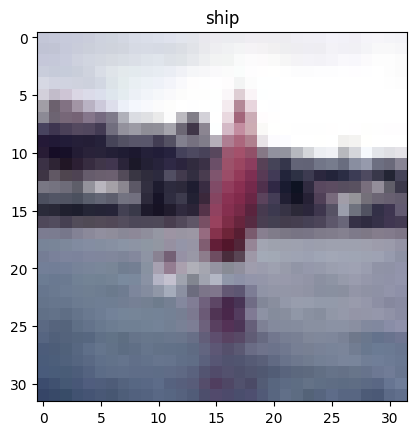

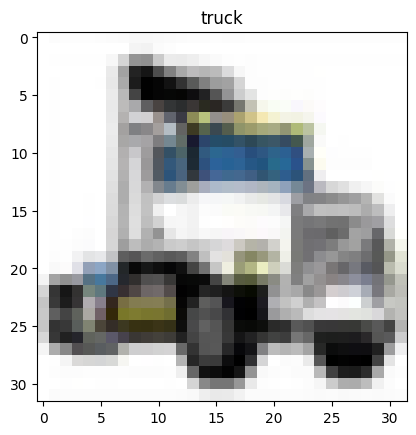

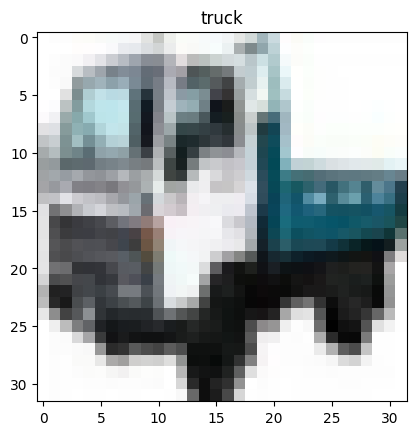

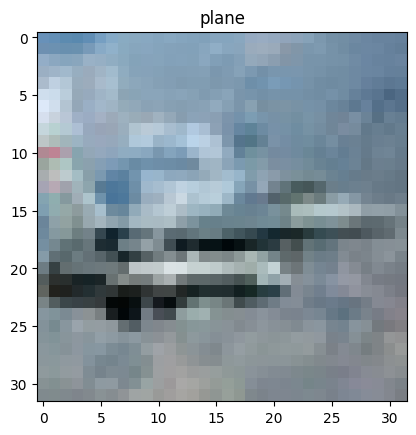

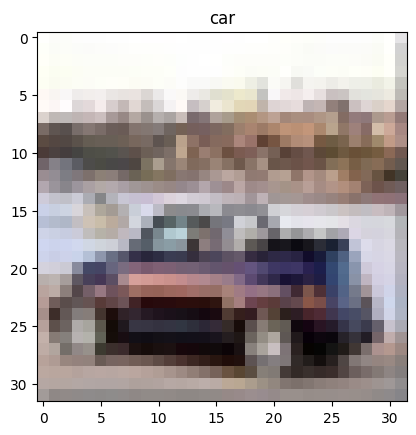

In [20]:
# ==============================================================================
#
#              CIFAR-10 Dataset
#
#
# ==============================================================================

# 1. Setup Dataset and DataLoader
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 2. Use CIFAR-10 dataset
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
dataiter = iter(train_loader)
images, labels = next(dataiter)


def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()


print("Example Images:")
for i in range(0, 5):
    imshow(images[i], title=classes[labels[i]])

While you wait for this subsequent training cell to run, you can start reading Part 2.7.

In [27]:
# ==============================================================================
#
#              Run a Training Loop for One Epoch
#
#
# ==============================================================================

# Initialize Model, Loss, and Optimizer
model = VisionTransformer(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=10,
    embed_dim=64,
    depth=8,
    mlp_ratio=4.0,
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)
epochs = 2


# The Training Loop
def train_one_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    pbar = tqdm(loader, desc=f"Epoch {epoch + 1}/{epochs}")

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # 1. Zero the gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(images)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass and optimization
        loss.backward()
        optimizer.step()

        # 5. Track statistics
        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy


print("\nStarting training for two epoch...")
for epoch in range(epochs):
    avg_loss, accuracy = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )
    print(f"\n--- End of Epoch {epoch}---")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {accuracy:.2f}%")


Starting training for two epoch...


Epoch 1/2:   0%|          | 0/782 [00:00<?, ?it/s]


--- End of Epoch 0---
Average Training Loss: 1.7820
Training Accuracy: 33.82%


Epoch 2/2:   0%|          | 0/782 [00:00<?, ?it/s]


--- End of Epoch 1---
Average Training Loss: 1.5057
Training Accuracy: 45.29%


After a single epoch, the performance is already much better than random chance (10 percent given there are 10 classes).

### Part 2.7: Loading Pretrained ViT

As mentioned in the introduction, it is common to start from a pretrained model, which has already learned a robust, general understanding of the visual world from a dataset like ImageNet-1k (containing 1 million images). Let's give this a go now and run the pretrained model on a few samples of the CIFAR-10 test set and compare to what we get from evaluating our much smaller model!


--- Evaluating on 10 samples from the CIFAR-10 test set ---


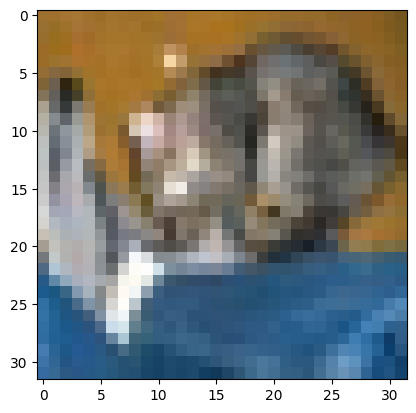


Image #1:
True Label (CIFAR-10) = 'cat'
Predicted class Pretrained: tabby, tabby cat
Predicted class Ours: cat
------------------------------


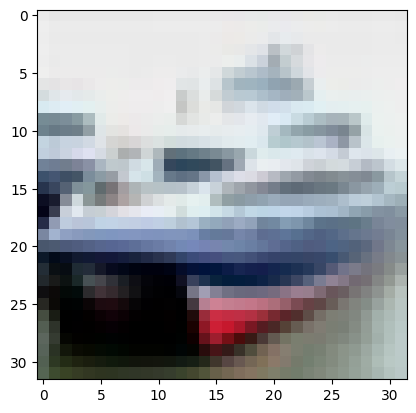


Image #2:
True Label (CIFAR-10) = 'ship'
Predicted class Pretrained: speedboat
Predicted class Ours: ship
------------------------------


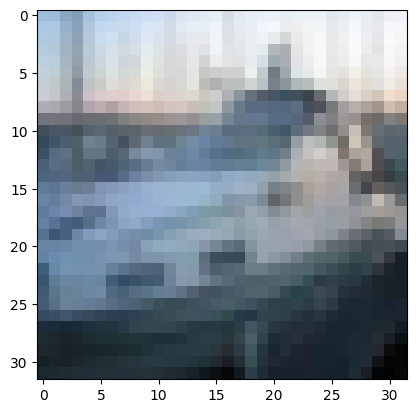


Image #3:
True Label (CIFAR-10) = 'ship'
Predicted class Pretrained: speedboat
Predicted class Ours: ship
------------------------------


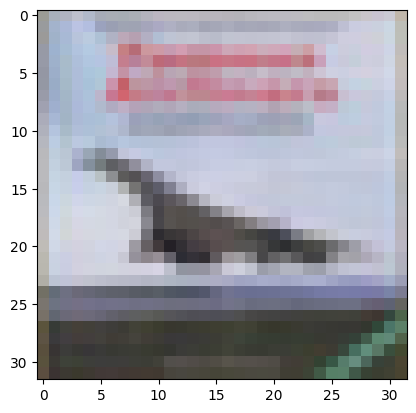


Image #4:
True Label (CIFAR-10) = 'plane'
Predicted class Pretrained: book jacket, dust cover, dust jacket, dust wrapper
Predicted class Ours: plane
------------------------------


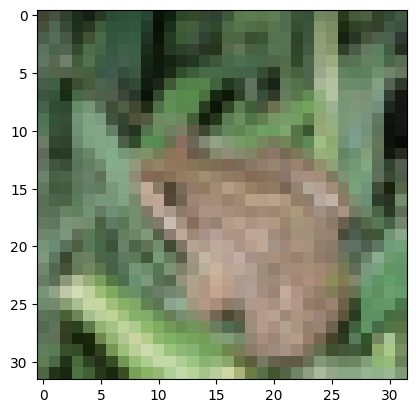


Image #5:
True Label (CIFAR-10) = 'frog'
Predicted class Pretrained: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
Predicted class Ours: deer
------------------------------


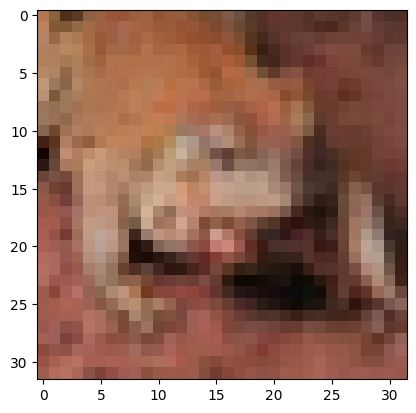


Image #6:
True Label (CIFAR-10) = 'frog'
Predicted class Pretrained: frilled lizard, Chlamydosaurus kingi
Predicted class Ours: frog
------------------------------


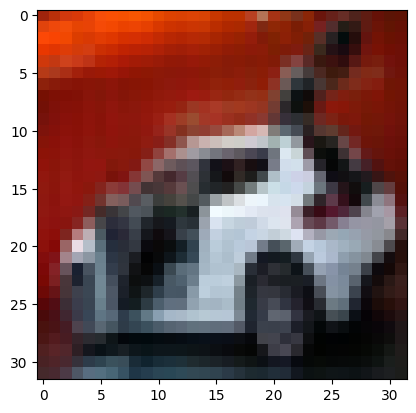


Image #7:
True Label (CIFAR-10) = 'car'
Predicted class Pretrained: lifeboat
Predicted class Ours: car
------------------------------


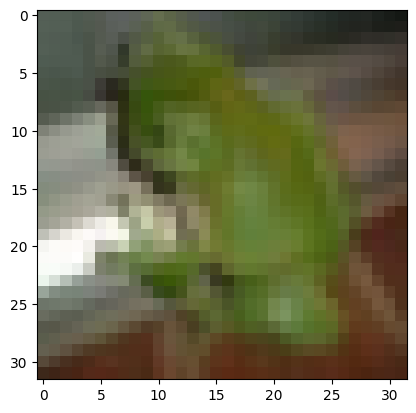


Image #8:
True Label (CIFAR-10) = 'frog'
Predicted class Pretrained: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
Predicted class Ours: bird
------------------------------


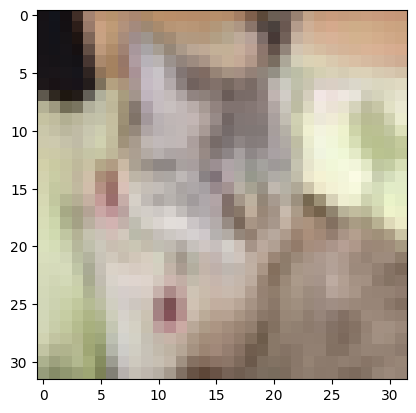


Image #9:
True Label (CIFAR-10) = 'cat'
Predicted class Pretrained: Egyptian cat
Predicted class Ours: cat
------------------------------


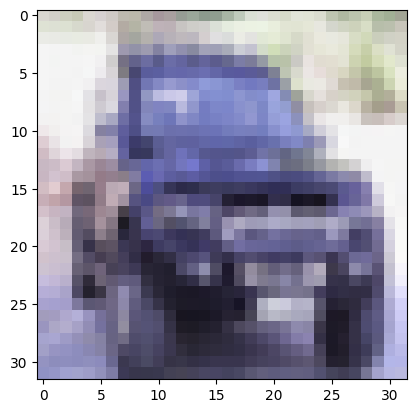


Image #10:
True Label (CIFAR-10) = 'car'
Predicted class Pretrained: moving van
Predicted class Ours: car
------------------------------


In [29]:
# ==============================================================================
#
#        Inference with a Pretrained ViT
#
# ==============================================================================
from torchvision.transforms import Resize

# Load the pretrained Vision Transformer model
from transformers import ViTForImageClassification


model_pt = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
model_pt = model_pt.to(device)
model_pt.eval()  # Set the model to evaluation mode
model.eval()

# Create a resize transform object
resize_transform = Resize((224, 224), antialias=True)

print("\n--- Evaluating on 10 samples from the CIFAR-10 test set ---")

# 1. Use torch.no_grad() for inference
with torch.no_grad():
    # 2. Get just one batch of images and labels from the test loader
    images, labels = next(iter(test_loader))

    # 3. Resize the entire batch of images to 224x224 to match input size of pretrained model
    images_rs = resize_transform(images)

    # 4. Move data to the selected device
    images_rs = images_rs.to(device)
    labels = labels.to(device)

    # 5. Get model predictions (logits)
    outputs_ours = model(images.to(device))
    outputs_pt = model_pt(images_rs)
    logits = outputs_pt.logits

    # Print results for the first 10 images in the batch
    for i in range(10):
        true_label = classes[labels[i]]
        prediction_pt = logits[i].argmax(-1)
        prediction_ours = outputs_ours.data[i].argmax(-1)
        imshow(images[i])
        print(f"\nImage #{i + 1}:")
        print(f"True Label (CIFAR-10) = '{true_label}'")
        print(
            "Predicted class Pretrained:",
            model_pt.config.id2label[prediction_pt.item()],
        )
        print("Predicted class Ours:", classes[prediction_ours])
        print("-" * 30)

## Part 3: Self-supervised Learning via [MAEs](https://arxiv.org/abs/2111.06377)

Above, you saw how we might train a vision encoder with labeled data using a classification loss function. But what happens if we do not have labels?

There are many techniques that can be classified as "self-supervised" where we use the data itself to generate "pre-text" tasks that allow the model to learn representations from data without labels. One very common and popular method is known as Masked Autoencoders (MAE). The core idea is that a model will learn useful visual representations by having to reconstruct full images from partial (masked) views.

<center>
<img src="https://imgs.search.brave.com/qiyXKwMm8_rkR9Tewvtcv2wM0rxNBn8PPVj6gddvYS4/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly90b3dh/cmRzZGF0YXNjaWVu/Y2UuY29tL3dwLWNv/bnRlbnQvdXBsb2Fk/cy8yMDIxLzEyLzFs/OHpQVjFzU0RtRVBi/d0hURGg1Unp3LnBu/Zw">
</center>

In this section, we will delve into how this works and implement a simple example.

### Part 3.1: Implementing the mean-squared error loss

The goal of the MAE is to reconstruct the original image from a partial, masked input. To measure how well the model is doing, we need a loss function. For image reconstruction, a common and effective choice is the **Mean Squared Error (MSE)**, which calculates the average squared difference between the predicted pixels and the true pixels.

Your task is to implement this loss. You will compare the model's prediction with the original, unmasked image.

$$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\text{prediction}_i - \text{target}_i)^2 $$

In [ ]:
# @title Hint 1 { display-mode: "form" }
# The task is to implement the Mean Squared Error (MSE) loss.

# Calculate the squared difference between each pixel.
# Then, calculate the mean of all the squared differences.
# The .mean() operation on the entire tensor computes the average
# over all dimensions (e.g., N, C, H, W), resulting in a single scalar value.

# Step 1: Solution
#   squared_error = (predictions - targets) ** 2
#   loss = torch.mean(squared_error)

# Example

# N = Batch Size, C = Channels, H = Height, W = Width
N, C, H, W = 4, 3, 32, 32

# Create some dummy prediction and target tensors
predictions = torch.randn(N, C, H, W)
targets = torch.randn(N, C, H, W)

# Calculate the squared difference between each element
squared_error = (predictions - targets) ** 2

# Calculate the mean of all the squared differences
loss = torch.mean(squared_error)

print(f"Calculated MSE Loss: {loss.item()}")

# Verification with PyTorch's built-in MSELoss
mse_loss_fn = torch.nn.MSELoss()
torch_loss = mse_loss_fn(predictions, targets)
print(f"PyTorch's MSE Loss: {torch_loss.item()}")

assert torch.allclose(loss, torch_loss), (
    "Your implementation does not match PyTorch's MSELoss."
)
print("\nSuccess! Your implementation is correct.")

In [ ]:
def reconstruction_loss(predictions, targets):
    """
    Calculates the Mean Squared Error between predictions and targets.
    This implementation does it manually to show the underlying operations.

    Args:
        predictions (torch.Tensor): The output from the MAE decoder.
                                    Shape: (N, C, H, W)
        targets (torch.Tensor): The original, unmasked images.
                                Shape: (N, C, H, W)
    Returns:
        torch.Tensor: The reconstruction loss value (a scalar).
    """
    # --- TODO 1: YOUR CODE HERE --- #
    # Calculate the squared difference between each pixel

    # Calculate the mean of all the squared differences.
    # The .mean() operation on the entire tensor computes the average
    # over all dimensions (N, C, H, W), resulting in a single scalar value.

    return loss
    # --- END YOUR CODE --- #

### Part 3.2: Masking Images for the MAE

This is the core mechanic of an MAE. We need a function that takes a batch of images and randomly masks a high percentage of their patches. In the original MAE paper, they use a 75% mask ratio.

The process is:
1.  Divide the image into a grid of non-overlapping patches.
2.  Randomly select a certain percentage of these patches to mask.
3.  Return the visible patches, the masked patches, and the indices that allow us to put them back together.

In [ ]:
# @title Hint 1 { display-mode: "form" }

# The task is to calculate the number of visible (unmasked) patches
# given a total number of patches and a mask ratio.

# 'L' represents the total number of patches from an image.
# 'mask_ratio' is the fraction of patches to be removed or hidden.
# The result 'len_keep' is the number of patches that will remain visible.

# Step 1: Solution
#   len_keep = int(L * (1 - mask_ratio))


# Let's assume an image is split into a sequence of patches.
# For a 224x224 image with 16x16 patches, L = (224/16) * (224/16) = 14 * 14 = 196.
L = 196  # Total number of patches
mask_ratio = 0.75  # We want to mask 75% of the patches

# --- Your implementation here ---
# Calculate the number of patches to keep (unmasked)
len_keep = int(L * (1 - mask_ratio))
# --- End of implementation ---

print(f"Total number of patches (L): {L}")
print(f"Mask ratio: {mask_ratio}")
print(f"Calculated number of visible patches (len_keep): {len_keep}")

# Verification
expected_len_keep = int(196 * (1 - 0.75))
assert len_keep == expected_len_keep, (
    f"Calculation is incorrect. Expected {expected_len_keep}."
)
print("\nSuccess! Your implementation is correct.")

In [ ]:
# @title Hint 2 { display-mode: "form" }

# The task is to select a subset of items (visible patches) from a sequence
# and create a corresponding binary mask.

# Step 1: Gather visible patches
#   We use torch.gather to select patches from the input tensor 'x'
#   based on the indices 'ids_keep'. The index tensor must be expanded
#   to match the dimensions of 'x'.
#   x_visible = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

# Step 2: Generate the binary mask
#   Create a tensor of all ones, with the same batch size (N) and
#   sequence length (L) as the original input.
#   mask = torch.ones([N, L], device=x.device)

# Step 3: Mark visible patches in the mask
#   Use .scatter_ to place zeros at the locations of the visible patches.
#   This modifies the mask in-place. The result is a mask where
#   0 indicates a visible patch and 1 indicates a masked patch.
#   mask.scatter_(dim=1, index=ids_keep, value=0)

# Example

# N = Batch Size, L = Sequence Length (total patches), D = Dimension per patch
N, L, D = 2, 10, 8
# Number of patches to keep visible
len_keep = 4

# Create a dummy input tensor (e.g., flattened image patches)
x = torch.randn(N, L, D)

# Generate random indices for the patches to keep (visible patches)
# In a real scenario, these would be the result of a shuffling operation.
noise = torch.rand(N, L)  # Noise to shuffle
ids_shuffle = torch.argsort(noise, dim=1)  # Sort noise to get shuffled indices
ids_keep = ids_shuffle[:, :len_keep]  # Keep the first 'len_keep' indices

# Gather the visible patches using the selected indices
# We need to expand ids_keep to match the dimensions of x for gathering
index_for_gather = ids_keep.unsqueeze(-1).repeat(1, 1, D)
x_visible = torch.gather(x, dim=1, index=index_for_gather)

# Generate the binary mask (0 for visible, 1 for masked)
mask = torch.ones([N, L], device=x.device)
# Use scatter_ to place 0s at the locations of the visible patches
mask.scatter_(dim=1, index=ids_keep, value=0)


print("--- Inputs ---")
print(f"Original sequence shape: {x.shape}")
print(f"Indices to keep (ids_keep):\n{ids_keep}")

print("\n--- Outputs ---")
print(f"Visible patches shape: {x_visible.shape}")
print(f"Binary mask (0=visible, 1=masked):\n{mask}")


# Verification
assert x_visible.shape == (N, len_keep, D), "Shape of x_visible is incorrect."
assert mask.shape == (N, L), "Shape of mask is incorrect."
# Verify that the number of visible patches (zeros) in the mask is correct
assert torch.sum(mask == 0).item() == N * len_keep, (
    "Mask does not have the correct number of visible patches."
)
print("\nSuccess! Your implementation is correct.")

In [ ]:
def random_masking(x, mask_ratio=0.75):
    """
    Takes a batch of flattened patches and randomly masks them.
    Args:
        x (torch.Tensor): Input tensor of shape (N, L, D) where N is batch size,
                          L is sequence length (num patches), D is patch dimension.
        mask_ratio (float): The ratio of patches to mask.
    Returns:
        tuple: A tuple containing:
            - x_visible (torch.Tensor): The visible (unmasked) patches.
            - mask (torch.Tensor): A binary mask indicating which patches were kept.
            - ids_restore (torch.Tensor): Indices to restore the original order.
    """
    N, L, D = x.shape

    # --- TODO 1: YOUR CODE HERE --- #
    # Calculate the number of visible (unmasked) patches via the mask_ratio

    # --- END YOUR CODE HERE --- #

    # Analogy: For each image in our batch, we shuffle a deck of cards (our patches).
    # `torch.rand` creates random floats, `torch.argsort` gives us the indices that would
    # sort them, which is a random permutation.

    noise = torch.rand(N, L, device=x.device)  # A random value for each patch
    ids_shuffle = torch.argsort(noise, dim=1)  # The shuffled indices

    # This is needed to put the patches back in their original positions later
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # Keep the first `len_keep` indices. These are our visible patches.
    ids_keep = ids_shuffle[:, :len_keep]

    # --- TODO 2: YOUR CODE HERE --- #

    # Gather the visible patches using the selected indices

    # Generate the binary mask for visualization and loss calculation
    # 0 for visible patches, 1 for masked patches

    # Put zeros for visible patches at the locations defined by ids_keep using
    # the .scatter_ function

    # --- END YOUR CODE HER --- #
    return x_visible, mask, ids_restore


# Helper function to visualize the masking process
def visualize_masking(patch_size=4, mask_ratio=0.75):
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # For visualization, let's take just one image
    img = images[0].unsqueeze(0)

    # 1. Patchify the image
    patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(
        img.shape[0], -1, 3 * patch_size * patch_size
    )

    # 2. Perform masking
    _, mask, _ = random_masking(patches, mask_ratio=mask_ratio)
    mask = (
        mask.detach()
        .cpu()
        .reshape(-1, img.shape[2] // patch_size, img.shape[3] // patch_size)
    )

    # 3. Create the masked image for visualization
    masked_img = img.clone().cpu()
    for i in range(mask.shape[1]):
        for j in range(mask.shape[2]):
            if mask[0, i, j] == 1:  # If the patch is masked
                masked_img[
                    0,
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ] = 0

    imshow(
        torchvision.utils.make_grid([images.cpu()[0], masked_img[0]]),
        title="Original vs. Masked",
    )


print("Visualizing the masking process (75% of patches are blacked out):")
visualize_masking(patch_size=4, mask_ratio=0.75)

### Part 3.3 The MAE Model Architecture

Now we define the model itself. It consists of three main parts:

1.  **Patch + Positional Embedding:** This layer converts an image into a sequence of flattened patch embeddings. We also add positional embeddings to give the model information about where each patch is located in the original image.
2.  **ViT Encoder:** A standard Vision Transformer encoder. It processes the sequence of *visible* patches and outputs their learned representations.
3.  **ViT Decoder:** A lightweight Transformer decoder. It takes the encoded visible patches plus the mask tokens and reconstructs the full image.

You have already seen the EncoderBlock and implemented parts of it. We will create a replica of that here for the DecoderBlock as well. Your next task will be to integrate these blocks within the main `MaskedAutoencoderViT` class.

In [ ]:
# This block is the same as the encoder block but we call it DecoderBlock here for readability
DecoderBlock = EncoderBlock

In [ ]:
# @title Hint 1 { display-mode: "form" }

# The task is to append learnable mask tokens to a sequence of visible patch embeddings.
# This step reconstructs a full-length sequence to be fed into an encoder, like a Transformer,
# after the original input has had some of its patches removed.

# Step 1: Create the mask tokens tensor.
#   The mask_token is a learnable parameter, a single vector that will represent
#   all masked-out patches. We repeat it to match the batch size and the number of
#   masked patches.
#   num_masked = self.num_patches - x_visible.shape[1]
#   mask_tokens = self.mask_token.repeat(x_visible.shape[0], num_masked, 1)

# Step 2: Concatenate visible patches and mask tokens.
#   Combine the sequence of visible patch embeddings with the newly created
#   mask tokens along the sequence dimension (dim=1).
#   x_ = torch.cat([x_visible, mask_tokens], dim=1)

# Example

# --- Setup ---
# N = Batch Size, L = Total Sequence Length (total patches), D = Dimension per patch
N, L, D = 2, 16, 8
# Number of patches that are visible
len_keep = 4

# Simulate the visible patch embeddings (output from a previous step)
x_visible = torch.randn(N, len_keep, D)

# In a real model, mask_token is a learnable parameter.
# We'll simulate it here. It has a shape of (1, 1, D).
mask_token = torch.nn.Parameter(torch.zeros(1, 1, D))
# In a real scenario, this would be part of your model, e.g., self.mask_token.

# --- Your implementation here ---

# 1. Calculate the number of patches that were masked.
# The total number of patches is L. The number of visible patches is the
# length of the sequence dimension of x_visible.
num_masked = L - x_visible.shape[1]

# Create the tensor of mask tokens by repeating the learnable mask_token.
# It should match the batch size (N) and the number of masked patches.
mask_tokens = mask_token.repeat(N, num_masked, 1)

# 2. Concatenate the visible patch embeddings and the mask tokens.
x_ = torch.cat([x_visible, mask_tokens], dim=1)

# --- End of implementation ---


print("--- Inputs ---")
print(f"Visible patches shape: {x_visible.shape}")
print(f"Learnable mask_token shape: {mask_token.shape}")
print(f"Number of total patches (L): {L}")
print(f"Number of visible patches: {len_keep}")
print(f"Number of masked patches: {num_masked}")

print("\n--- Outputs ---")
print(f"Repeated mask_tokens shape: {mask_tokens.shape}")
print(f"Final concatenated sequence shape: {x_.shape}")


# Verification
# The final sequence should have the original total length L.
assert x_.shape == (N, L, D), "The final tensor shape is incorrect."
# The first part of the sequence should be the visible patches.
assert torch.all(x_[:, :len_keep, :] == x_visible), (
    "The visible patches were not concatenated correctly."
)
# The second part should be the mask tokens.
assert torch.all(x_[:, len_keep:, :] == mask_token), (
    "The mask tokens were not concatenated correctly."
)

print("\nSuccess! Your implementation is correct.")

In [ ]:
# @title Hint 2 { display-mode: "form" }

# Step 1: Patchify the input images.
#   Convert the batch of images into a sequence of flattened patches with positional embeddings.
#   patches = self.patch_embed(imgs)

# Step 2: Run the encoder.
#   Randomly mask a large portion of the patches and feed only the
#   visible patches through the encoder.
#   x_visible, mask, ids_restore = self.forward_encoder(patches, self.mask_ratio)

# Step 3: Run the decoder.
#   Append learnable mask tokens to the encoded visible patches,
#   restore the original sequence order, and run through the decoder
#   to predict the pixel values for the full image.
#   pred = self.forward_decoder(x_visible, ids_restore)

# Step 4: Unpatchify the prediction.
#   Reshape the sequence of predicted patches back into an image format.
#   recon_imgs = self._unpatchify(pred)

# Example


# --- Full MAE Model ---
class MaskedAutoencoderViTExample(nn.Module):
    """A simplified Masked Autoencoder with a Vision Transformer backbone."""

    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_chans=3,
        embed_dim=64,
        encoder_depth=8,
        decoder_depth=2,
        mlp_ratio=2.0,
        mask_ratio=0.75,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size**2

        self.patch_embed = PatchAndEmbed(img_size, patch_size, in_chans, embed_dim)
        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(embed_dim, mlp_ratio) for _ in range(encoder_depth)]
        )
        self.encoder_norm = nn.LayerNorm(embed_dim)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.decoder_embed = nn.Linear(embed_dim, embed_dim)
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )
        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(embed_dim, mlp_ratio) for _ in range(decoder_depth)]
        )
        self.decoder_norm = nn.LayerNorm(embed_dim)

        self.decoder_pred = nn.Linear(embed_dim, patch_dim)

    def _unpatchify(self, x):
        p = self.patch_size
        h = w = int(self.num_patches**0.5)
        C = x.shape[-1] // (p * p)
        x = x.reshape(x.shape[0], h, w, C, p, p)
        x = x.permute(0, 3, 1, 4, 2, 5).reshape(x.shape[0], C, h * p, w * p)
        return x

    def forward_encoder(self, x, mask_ratio):
        x_visible, mask, ids_restore = random_masking(x, mask_ratio)
        for blk in self.encoder_blocks:
            x_visible = blk(x_visible)
        x_visible = self.encoder_norm(x_visible)
        return x_visible, mask, ids_restore

    def forward_decoder(self, x_visible, ids_restore):
        x_visible = self.decoder_embed(x_visible)
        num_masked = self.num_patches - x_visible.shape[1]
        mask_tokens = self.mask_token.repeat(x_visible.shape[0], num_masked, 1)
        x_ = torch.cat([x_visible, mask_tokens], dim=1)
        x = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_.shape[2])
        )
        x = x + self.decoder_pos_embed
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        return x

    def forward(self, imgs):
        # 1. Patchify the input images.
        patches = self.patch_embed(imgs)

        # 2. Run the encoder.
        x_visible, mask, ids_restore = self.forward_encoder(patches, self.mask_ratio)

        # 3. Run the decoder.
        pred_patches = self.forward_decoder(x_visible, ids_restore)

        # 4. Unpatchify the prediction to get the reconstructed image.
        recon_imgs = self._unpatchify(pred_patches)

        # We also need the original images for the loss function, but here we just show the flow.
        return recon_imgs, mask


# --- Setup and Run ---
model = MaskedAutoencoderViTExample()
N, C, H, W = 2, 3, 32, 32
imgs = torch.randn(N, C, H, W)

recon_imgs, mask = model(imgs)

# --- Final Shapes ---
print(f"Original images shape:    {imgs.shape}")
print(f"Reconstructed images shape: {recon_imgs.shape}")
print(f"Mask shape:               {mask.shape}")
print(
    f"\nExample mask for first image (0=visible, 1=masked):\n{mask[0].reshape(8, 8).int()}"
)

assert recon_imgs.shape == imgs.shape, "Shape of reconstructed image is incorrect."
print("\nSuccess! The forward pass flow is correct.")

In [ ]:
class MaskedAutoencoderViT(nn.Module):
    """A simplified Masked Autoencoder with a Vision Transformer backbone."""

    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_chans=3,
        embed_dim=64,
        encoder_depth=8,
        decoder_depth=2,
        mlp_ratio=2.0,
        mask_ratio=0.75,
    ):
        super().__init__()
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_chans * patch_size**2

        # --- Patch + Positional Embeddings ---
        self.patch_embed = PatchAndEmbed(img_size, patch_size, in_chans, embed_dim)

        # --- Encoder ---
        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(embed_dim, mlp_ratio) for _ in range(encoder_depth)]
        )
        self.encoder_norm = nn.LayerNorm(embed_dim)

        # --- Decoder ---
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.decoder_embed = nn.Linear(embed_dim, embed_dim)
        self.decoder_pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(embed_dim, mlp_ratio) for _ in range(decoder_depth)]
        )
        self.decoder_norm = nn.LayerNorm(embed_dim)

        # --- Final Projection Head ---
        self.decoder_pred = nn.Linear(embed_dim, patch_dim)

    def _patchify(self, imgs):
        p = self.patch_size
        # (N, C, H, W) -> (N, L, C*P*P)
        x = imgs.unfold(2, p, p).unfold(3, p, p)
        x = x.permute(0, 2, 3, 1, 4, 5).reshape(imgs.shape[0], -1, 3 * p * p)
        return x

    def _unpatchify(self, x):
        p = self.patch_size
        h = w = int(self.num_patches**0.5)
        # (N, L, C*P*P) -> (N, C, H, W)
        x = x.reshape(x.shape[0], h, w, 3, p, p)
        x = x.permute(0, 3, 1, 4, 2, 5).reshape(x.shape[0], 3, h * p, w * p)
        return x

    def forward_encoder(self, x, mask_ratio):
        # Masking
        x_visible, mask, ids_restore = random_masking(x, mask_ratio)

        # Run through encoder blocks
        for blk in self.encoder_blocks:
            x_visible = blk(x_visible)
        x_visible = self.encoder_norm(x_visible)

        return x_visible, mask, ids_restore

    def forward_decoder(self, x_visible, ids_restore):
        x_visible = self.decoder_embed(x_visible)

        # --- TODO 1: YOUR CODE HERE --- #
        # 1. Create the mask tokens tensor by repeating the learnable `mask_token`.
        # The number of mask tokens needed is `num_patches - num_visible_patches`.

        # 2. Concatenate the visible patch embeddings and the mask tokens together.

        # --- END YOUR CODE --- #

        # 3. Use `ids_restore` to unshuffle the sequence back to its original patch order.
        x = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_.shape[2])
        )

        # Add decoder positional embeddings
        x = x + self.decoder_pos_embed

        # Run through decoder blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # Final prediction head
        x = self.decoder_pred(x)
        return x

    def forward(self, imgs):
        # --- TODO 2: YOUR CODE HERE --- #
        # 1. Patchify the input images.

        # 2. Run the encoder.

        # 3. Run the decoder.

        # 4. Unpatchify the prediction to get the reconstructed image.

        # --- END YOUR CODE --- #

        # We also need the original images for the loss function.
        return recon_imgs, imgs

## Part 3.4: Visualize the Reconstructed Output (Before Training)

Let's see what our randomly initialized model produces. We'll pass a batch of images through it and visualize the output. Since the model hasn't learned anything, the reconstruction will look like random noise. This provides a good baseline to see how much the model improves with training.

In [ ]:
def show_reconstruction(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    images, _ = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        recon_imgs, orig_imgs = model(images)

    # Create masked image for visualization
    # This requires running parts of the model again to get the mask
    patches = model._patchify(images)
    _, mask, _ = random_masking(patches, model.mask_ratio)
    mask = mask.detach().reshape(-1, model.num_patches)

    # Recreate the masked images
    masked_patches = patches.clone()
    for i in range(masked_patches.shape[0]):
        masked_patches[i, mask[i] == 1, :] = 0  # Black out masked patches
    masked_imgs = model._unpatchify(masked_patches)

    # Move to CPU and create grids for display
    orig_grid = torchvision.utils.make_grid(orig_imgs.cpu())
    masked_grid = torchvision.utils.make_grid(masked_imgs.cpu())
    recon_grid = torchvision.utils.make_grid(recon_imgs.cpu())

    plt.figure(figsize=(8, 8))
    imshow(orig_grid, title="Original Images")
    plt.figure(figsize=(8, 8))
    imshow(masked_grid, title="Masked Images")
    plt.figure(figsize=(8, 8))
    imshow(recon_grid, title="Reconstructed Images")
    model.train()  # Set model back to training mode


# Instantiate the model
model_mae = MaskedAutoencoderViT(
    img_size=32,
    patch_size=4,
    embed_dim=64,
    encoder_depth=4,
    decoder_depth=1,
    mlp_ratio=2.0,
    mask_ratio=0.75,
).to(device)

print("Model architecture:", model_mae)
print("\nVisualizing initial random reconstruction:")
show_reconstruction(model_mae, test_loader, device)

### Part 3.5: Running a training loop and visualizing reconstructions!

Now that we have all the pieces, we can train a simple ViT based MAE. After training, the model learns to reconstruct images better and better. At convergence, the encoder will have learned to represent images in a latent embedding vector that is useful for image reconstruction via a shallow decoder. By doing this, this embedding can then be used for other tasks just like from supervised training.

In [ ]:
# Training Configuration
epochs = 4  # Increase this for better results
lr = 1.5e-4
wd = 0.05

optimizer = torch.optim.AdamW(model_mae.parameters(), lr=lr, weight_decay=0.05)

print("Starting training...")
model_mae.train()

for epoch in range(epochs):
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
    for imgs, _ in pbar:
        imgs = imgs.to(device)

        # Forward pass
        recon_imgs, orig_imgs = model_mae(imgs)
        loss = reconstruction_loss(recon_imgs, orig_imgs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.4f}")

    # Visualize progress every 5 epochs
    if (epoch + 1) % 1 == 0:
        print(f"\n--- Visualizing reconstruction after epoch {epoch + 1} ---")
        show_reconstruction(model_mae, test_loader, device)
        print("--------------------------------------------------\n")

print("Training finished!")

### Part 3.6 Using a Pre-trained MAE representation for tasks!

Previously we trained our CIFAR-10 ViT classifier from scratch. In 1 epoch we achieved 35% accuracy. What if we initialized our vision encoder from the encoder within the MAE we just trained? We can see that this encoder must have learned about the general structure of images and *encoded* that in it's 64 dimensional embedding. Now we'll see how well our classifier does if we train it for 1 epoch but with the encoder initialized with this pre-trained encoder.

We will first create a class to wrap a pretrained patch embedding and encoder with a classifier head. We then initialize the patch_embedding, and encoder blocks to those that we just trained with the MAE.

In [ ]:
class ClassifyWithMAE(nn.Module):
    def __init__(self, patch_layer, encoder, embed_dim=64, num_classes=10):
        super().__init__()
        self.patch_and_embed = patch_layer
        self.encoder = encoder

        # Classification Head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_and_embed(x)
        for blk in self.encoder:
            x = blk(x)
        # After the final block, the sequence is normalised
        x = self.norm(x)

        x = x.mean(dim=1)
        logits = self.head(x)

        return logits


model_mae_cls = ClassifyWithMAE(
    model_mae.patch_embed, model_mae.encoder_blocks, embed_dim=64, num_classes=10
)
model_mae_cls.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_mae_cls.parameters(), lr=1.5e-4)
epochs = 1
print("\nStarting training for one epoch...")
epoch = 0
for epoch in range(epochs):
    avg_loss, accuracy = train_one_epoch(
        model_mae_cls, train_loader, criterion, optimizer, device, epoch
    )
    print("\n--- End of Epoch ---")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {accuracy:.2f}%")

In the supevised training of the same ViT architecture from scratch that we did earlier: [Supervised Training](#scrollTo=E3MxL7AWaVtK&line=52&uniqifier=1), we saw that in 1 epoch we achieved a training accuracy of approximately 34%. Now by initializing the encoder from the MAE we get a 4% boost! This shows that pretraining (even with a self-supervised task unrelated to classification) can improve the efficiency of learning during task adaptation!

### Part 4 (Take-home task): Contrastive Language-Image Pre-training (CLIP)

CLIP aims to learn visual concepts through large-scale image-text pairs, widely available on the web. It operates by training a text encoder and image encoder to match captions with corresponding images.

Specifically, given a batch of image-text pairs, CLIP computes the dense cosine similarity matrix between all possible (image, text) candidates within this batch. The core idea is to **maximize the similarity between the correct pairs** (shown in blue in the figure below) and **minimize the similarity for incorrect pairs** (shown in grey in the image). To do it, they optimize a symmetric cross-entropy loss over these similarity scores.

<center>
<img src="https://images.openai.com/blob/fbc4f633-9ad4-4dc2-bd94-0b6f1feee22f/overview-a.svg">
</center>

Note that the Image Encoder and Text Encoder work together to project both images and text into a single, **multi-modal embedding space** where they can be compared.

CLIP's ability to connect language and vision unlocks a wide range of powerful applications:

- **Image and Text Similarity Search**: Find images that best match a text query or find text that best describes an image.

- **Vision-Language Modelling**: The trained CLIP Vision Encoder can be used to embed images and train LLMs on image-text data for applications such as visual question answering and image captioning (more details on this in tomorrow's lecture on VLMs).

To get hands-on with CLIP, you can work through the exercise from last year's [tutorial](https://colab.sandbox.google.com/github/eemlcommunity/PracticalSessions2024/blob/main/3_vision_language_models/VLM_tutorial.ipynb#scrollTo=Lugc4X-2Ls9g).



### Part IV: Conclusion

Congratulations on completing this deep dive into training Vision Transformer encoders! 🥳 We covered:

- **Fully Supervised Learning**: We began with the classic approach, teaching models to map images to explicit, human-provided labels.

- **Self-Supervised Learning (SSL)**: We then explored the clever world of Masked Autoencoders (MAE), where models learn rich features by solving the "puzzle" of reconstructing parts of an image.

- **Contrastive Learning**: Finally, we saw how models like CLIP can align vision and language in a shared semantic space by learning from massive, noisy datasets of image-text pairs.

By mastering these methodologies, you have grasped the foundational principles behind most state-of-the-art vision backbones.

In practice, the lines between these approaches are blurring. State-of-the-art research frequently combines them using hybrid loss functions to get the best of all worlds. For instance, a model might combine:

- A **contrastive loss** (like CLIP's) to learn high-level semantic understanding.

- A **reconstruction loss** (like MAE's) to ensure it also captures fine-grained, pixel-level details.

The CoCa paper, which simultaneously performs contrastive and captioning losses, is a prime example.




### Recommended Reading


To continue your journey, we highly recommend exploring the original papers that introduced these groundbreaking ideas and related works.

- ViT: Dosovitskiy et al. (2020). [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.](https://arxiv.org/abs/2010.11929)

- MAE: He et al. (2021). [Masked Autoencoders Are Scalable Vision Learners.](https://arxiv.org/abs/2111.06377)

- DINO: Caron et al. (2021). [Emerging Properties in Self-Supervised Vision Transformers.](https://arxiv.org/abs/2104.14294)

- CLIP: Radford et al. (2021). [Learning Transferable Visual Models From Natural Language Supervision.](https://arxiv.org/abs/2103.00020)

- CoCa: Yu et al. (2022). [CoCa: Contrastive Captioners are Image-Text Foundation Models.](https://arxiv.org/abs/2205.01917)

- Swin Transformer: Liu et al. (2021). [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows.](https://arxiv.org/abs/2103.14030)

- BEiT: Bao et al. (2021). [BEiT: BERT Pre-Training of Image Transformers.](https://arxiv.org/abs/2106.08254)

- SimCLR: Chen et al. (2020). [A Simple Framework for Contrastive Learning of Visual Representations.](https://arxiv.org/abs/2002.05709)

- MoCo: He et al. (2019). [Momentum Contrast for Unsupervised Visual Representation Learning.](https://arxiv.org/abs/1911.05722)